In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_predictions(X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor, y_pred: torch.Tensor, model: nn.Module) -> None:
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.scatter(X_test.cpu().numpy(), y_test.cpu().numpy(), color='darkturquoise', edgecolors='black', label='Test data')
    ax.scatter(X_train.cpu().numpy(), y_train.cpu().numpy(), color='darksalmon', edgecolors='black', label='Train data')
    ax.scatter(X_test.cpu().numpy(), y_pred.detach().cpu().numpy(), color='yellowgreen', edgecolors='black', label='Predictions')
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    ax.set_title('Predictions', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
    ax.legend(prop={'size': 10, 'style': 'italic'})
    plt.show()

def plot_curves(epoch_count: np.ndarray, train_loss_values: np.ndarray, test_loss_values: np.ndarray) -> None:
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(epoch_count, train_loss_values, label='Train loss', color='darkturquoise')
    ax.plot(epoch_count, test_loss_values, label='Test loss', color='darksalmon')
    ax.set_title('Loss over epochs', loc='left', fontdict={'fontsize': 14, 'fontstyle': 'italic'})
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

In [3]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float32))
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.
        Args:
            X (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor after applying linear transformation.
        """
        return self.weight * X + self.bias

# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the model
model_0 = LinearRegressionModel()

# Print the model's parameters
print("Model parameters before training:")
model_0.state_dict()

Model parameters before training:


OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Cargamos los datos

In [4]:
train_data = torch.load('temp/data/train_data.pt')
test_data = torch.load('temp/data/test_data.pt')

X_train = train_data[:, 0]
y_train = train_data[:, 1]
X_test = test_data[:, 0]
y_test = test_data[:, 1]

- *Más adelante vamos a explicar que hace `torch.inference_mode()`. Por ahora, es simplmente una manera que tenemos de generar predicciones con nuestro modelo.*

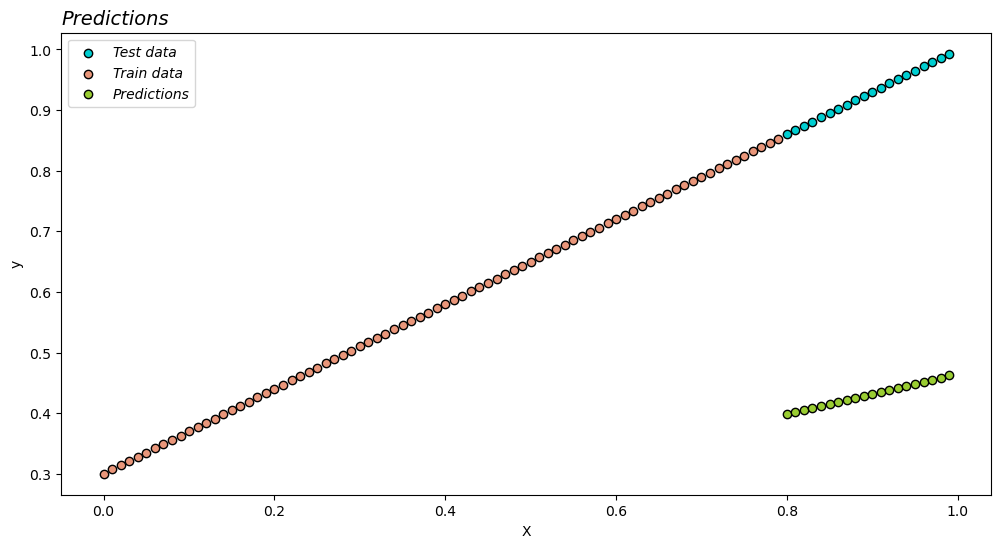

In [5]:
with torch.inference_mode():
    predictions = model_0(X_test)
    predictions = predictions

plot_predictions(X_train, y_train, X_test, y_test, predictions, model_0)

### Funciones de pérdida

- *`torch.nn` es un paquete que contiene implementaciones para varias de las funciones de pérdida más utilizadas. La lista completa está disponible en la [documentación](https://docs.pytorch.org/docs/stable/nn.html#loss-functions).*
- *Estas funciones estan implementadas (y optimizadas) en lenguajes de programación de muy bajo nivel, como C o CUDA, por lo que son significativamente más rápidas que una función de Python. Además, se integran muy fácilmente con `torch.autograd`, el modulo que utiliza PyTorch para ejecutar back-propagation.*
- *Para definir la función de pérdida a utilizar, solo necesitamos con crear una instancia.*

In [6]:
loss_function = nn.L1Loss()
print(f'{loss_function}: {loss_function.__class__}')

L1Loss(): <class 'torch.nn.modules.loss.L1Loss'>


### Optimizador

- *`torch.optim` es un paquete que contiene implementaciones para la gran mayoría de los algoritmos de optimización que se utilizan en Deep Learning.*
- *Todos los algoritmos implementados por PyTorch (o que construyamos nosotros) van a ser una sub-clase de la clase base `Optimizer`. Esta clase nos proporciona la estructura básica a partir de la cual el resto de los algoritmos van a funcionar.*
- *En particular, esta clase es la encargada de guardar una referencia de todos los parámetros que necesitan ser optimizados, de guardar información sobre el estado actual de los parámetros y, lo más importante, actualizar los parámetros durante el entrenamiento utilizando métodos como `zero_grad()` o `step()`.*
    - *Las implementaciones de algoritmos como SGD o Adam heredan estas funcionalidades para luego poder implementar sus propias reglas de actualización.*
- *Al crear una instancia de la clase `Optimizer`, es necesario pasarle un objeto iterable que contenga todos los parámetros del modelo (tienen que ser instancias de `nn.Parameters`), así `Optimizer` tiene una referencia de los parámetros que debe optimizar.*
    - *También podemos definir valores para los hiperparámetros del optimizador como, por ejemplo, el learning-rate.*

In [7]:
# We can give the optimizer an iterable object with all the parameters
optimizer_1 = optim.SGD(
    params=model_0.parameters(), 
    lr=0.01,
    momentum=0.9
)

# Or we can give named parameters
optimizer_2 = optim.Adam(
    params=model_0.named_parameters(),
    lr=0.001
)

- *`Optimizer` nos da la posibilidad de definir grupos de parámetros dentro de una misma instancia. Esto es muy útil cuando queremos definir diferentes hiperparámetros para distintos tipos de parámetros.*
- *En vez de pasar un objeto iterable como `model.parameters()`, podemos pasar una lista de diccionarios con los parámetros que integran cada grupo. Estos diccionarios deben contener una llave que se llame `params`, la cual va a referenciar a los parámetros incluidos en el grupo, y también los hiperparámetros que queremos especificar para ese grupo.*
- *Más información sobre como definir grupos de parámetros, y lo que se puede hacer con ellos, en la [documentación](https://docs.pytorch.org/docs/stable/optim.html#per-parameter-options).*

In [8]:
optimizer = optim.SGD(
    params=[
        {'params': model_0.weight, 'lr': 0.01},
        {'params': model_0.bias}
    ],
    lr=0.001
)

- *Hay tres posibles maneras de implementar los algoritmos de optimización en PyTorch:*
    - *`for-loop`. Procesa cada tensor de parámetros de manera individual, actualizando los parámetros de manera secuencial dentro de un loop de Python.*
    - *`foreach` (default). Utiliza operaciones vectorizadas para procesar múltiples tensores de forma simultánea. En otras palabras, genera un batch con los parámetros del modelo, y los actualiza simultáneamente.*
    - *`fused`. Esta es la implementación más rápida disponible, ya que combina múltiples tensores en un único kernel de CUDA, evitando así tener que utilizar memoría durante este proceso. Sin embargo, solo está disponible para algunos optimizadores (e.g., Adam o SGD) y sólo se puede utilizar en GPUs.*

### Training Loop

0. *`epochs`. Define la cantidad de épocas que vamos a entrenar nuestro modelo. Una época equivale a una iteración completa sobre el dataset.*
1. *`model.train()`. Pone nuestro modelo en modo de entrenamiento.*
    - *Este paso es muy importante porque se encarga de modificar el funcionamiento de ciertas capas de la red neuronal.*
    - *Por ejemplo, si queremos utilizar dropout, necesitamos que durante el entrenamiento se vayan apagando neuronas de forma aleatoria (para así poder evitar el sobreajusta), pero durante la evaluación necesitamos que todas las neuronas estén prendidas.*
2. *`forward()`. Pasamos nuestros datos de entrenamiento a la red neuronal para que genere las predicciones.*
    - *Notar que no es necesario llamar explícitamente al método `forward()`, ya que se ejecuta cuando llamamos a nuestro modelo.*
3. *`loss_function()`. Usamos la función de pérdida para medir que tan bien está ajustando nuestro modelo a los datos, es decir, que tan acertada es nuestra predicción.*
    - *Tenemos que pasarle las predicciones, `y_pred`, y el ground-truth, `y_train`.*
4. *`zero_grad()`. Cambia el valor de los gradientes a cero.*
    - *Este paso es importante porque, por defecto, PyTorch acumula los gradientes. Es decir, cuando PyTorch computa los gradientes, no reemplaza el valor existente en memoria por un nuevo valor, sino que agrega ese nuevo valor al ya existente.*
5. *`.backward()`. Aplica backpropagation para computar los gradientes de la función de pérdida con respecto a los pesos de la red neuronal.*
    - *Utiliza `torch.autograd` para computar los gradientes de los parámetros que tienen `requires_grad=True`.*
6. *`optim.Optimizer.step()`. Actualiza los pesos de la red neuronal.*
    - *Cada algoritmo aplica una regla de actualización diferente, pero todos utilizando los gradientes para moverse en la dirección que genera la mayor reducción en la función de pérdida.*

### Testing Loop

*Dentro de este loop generamos las predicciones para la muestra de evaluación/validación, calculamos la función de pérdida (para comparar con las predicciones durante el entrenamiento), y calculamos cualquier métrica adicional como el accuracy (en problemas de clasifcación) o el coeficiente de determinación (en problemas de regresión).*

1. *`model.eval()`. Pone nuestro modelo en modo de evaluación.*
    - *Desactiva las funcionalidades que se activaron durante el entrenamiento y que no son necesarias durante la evaluación, como dropout.*
2. *`torch.inference_mode()`. Es un context manager que nos permite realizar operaciones que no interactúan con `torch.autograd` de forma más eficiente, dado que inhabilita ciertas funcionalidades como el computo de los gradientes o seguimiento de versiones.*
    - *También se puede utilizar como un decorator de Python. Mirar la [documentación](https://docs.pytorch.org/docs/stable/generated/torch.autograd.grad_mode.inference_mode.html#inference-mode) para más información.* 

In [9]:
# An epoch is one complete pass through the dataset
epochs = 150

# Creates a NumPy array to store the loss functions values
epoch_count = np.arange(epochs)
train_loss_values = np.zeros(epochs)
test_loss_values = np.zeros(epochs)

for epoch in np.arange(epochs):
    ##### Training Loop #####

    # Set the model to training mode
    model_0.train()

    # Foward pass
    # We don't have to call the `forward()` method explicitly, because it's called automatically when the model is called
    y_pred = model_0(X_train)

    # Calculate the loss
    train_loss = loss_function(y_pred, y_train)
    train_loss_values[epoch] = train_loss.item()

    # Zero the gradients
    # This is an important step, because by default, gradients are accumulated in PyTorch
    # If we don't zero the gradients, the gradients will be added to the previous gradients
    optimizer_1.zero_grad()

    # Backward pass
    # This calculates the gradients of the loss with respect to the model parameters
    train_loss.backward()

    # Update the model parameters
    optimizer_1.step()

    ### Validation Loop #####

    # Set the model to evaluation mode
    model_0.eval()

    # Turn on inference mode.
    with torch.inference_mode():
        # Forward pass
        y_test_pred = model_0(X_test)

        # Calculate the loss for the test set
        test_loss = loss_function(y_test_pred, y_test)
        test_loss_values[epoch] = test_loss.item()

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} |  Train loss: {train_loss.item()} | Test loss: {test_loss.item()}')

Epoch: 0 |  Train loss: 0.31469789147377014 | Test loss: 0.48281747102737427
Epoch: 10 |  Train loss: 0.1036403551697731 | Test loss: 0.028235837817192078
Epoch: 20 |  Train loss: 0.06930108368396759 | Test loss: 0.19414445757865906
Epoch: 30 |  Train loss: 0.04804597049951553 | Test loss: 0.02628118172287941
Epoch: 40 |  Train loss: 0.021848704665899277 | Test loss: 0.0022193104960024357
Epoch: 50 |  Train loss: 0.01211298257112503 | Test loss: 0.003174680517986417
Epoch: 60 |  Train loss: 0.0036201192997395992 | Test loss: 0.0017908543813973665
Epoch: 70 |  Train loss: 0.0037184790708124638 | Test loss: 0.014607754535973072
Epoch: 80 |  Train loss: 0.002394766081124544 | Test loss: 0.013761365786194801
Epoch: 90 |  Train loss: 0.013728810474276543 | Test loss: 0.018809303641319275
Epoch: 100 |  Train loss: 0.022265315055847168 | Test loss: 0.01836520992219448
Epoch: 110 |  Train loss: 0.014954999089241028 | Test loss: 0.021119188517332077
Epoch: 120 |  Train loss: 0.02183780446648597

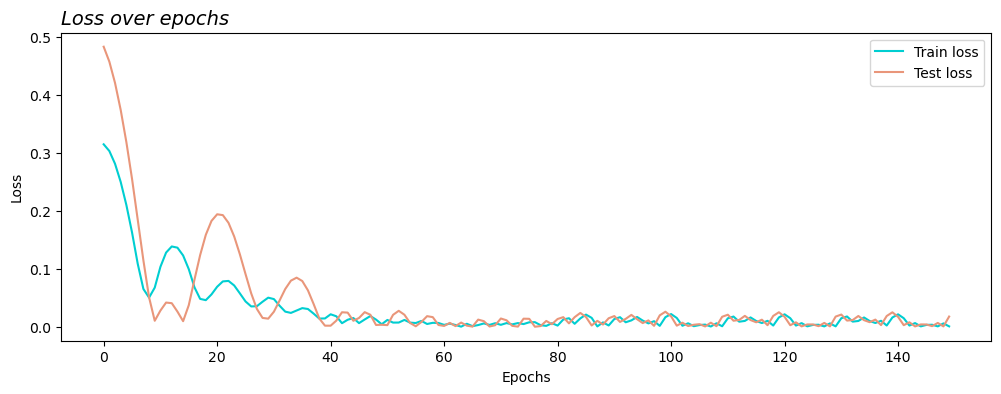

In [10]:
plot_curves(epoch_count, train_loss_values, test_loss_values)

- *Podemos usar `torch.inference_mode()` por fuera del training loop para computar las predicciones de nuestro modelo. Podemos ver un cambio significativo entre las predicciones que hicimos al principio, con los parámetros inicializados aleatoriamente, y las predicciones actuales, después de haber ajustado los parámetros utilizando SGD.*

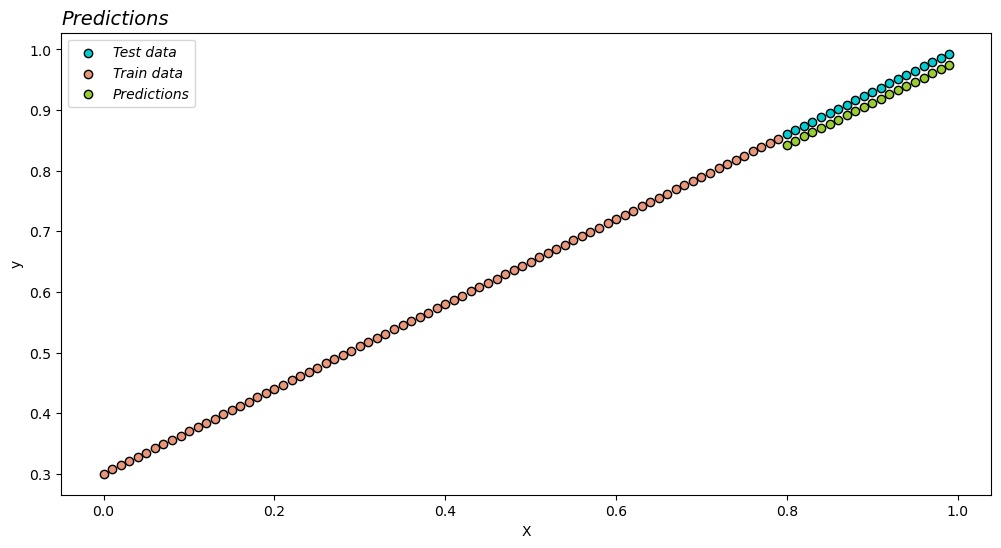

In [11]:
model_0.eval()

with torch.inference_mode():
    predictions = model_0(X_test)
    predictions = predictions

plot_predictions(X_train, y_train, X_test, y_test, predictions, model_0)